In [105]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from kmodes.kprototypes import KPrototypes

##### Overview of the dataset

In [62]:
data1 = pd.read_csv("/kaggle/input/customer-segmentation/Train.csv")
data2 = pd.read_csv("/kaggle/input/customer-segmentation/Test.csv")
data= pd.concat([data1,data2], axis=0)
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (10695, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB
None


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


##### Data Cleaning: Removing duplicates

In [63]:
data.duplicated()
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10657 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10657 non-null  int64  
 1   Gender           10657 non-null  object 
 2   Ever_Married     10468 non-null  object 
 3   Age              10657 non-null  int64  
 4   Graduated        10557 non-null  object 
 5   Profession       10495 non-null  object 
 6   Work_Experience  9567 non-null   float64
 7   Spending_Score   10657 non-null  object 
 8   Family_Size      10210 non-null  float64
 9   Var_1            10549 non-null  object 
 10  Segmentation     10657 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 999.1+ KB


##### Data Cleaning: Dropping columns with Feature leakage and High Cardinality

In [64]:
data.drop(["ID","Var_1","Segmentation"], axis="columns",inplace=True)
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


##### Inspecting the categorical variables and numerical variables

In [65]:
print(data.select_dtypes("object").nunique())
print(data.describe())

Gender            2
Ever_Married      2
Graduated         2
Profession        9
Spending_Score    3
dtype: int64
                Age  Work_Experience   Family_Size
count  10657.000000      9567.000000  10210.000000
mean      43.537956         2.624334      2.843781
std       16.769600         3.393428      1.536758
min       18.000000         0.000000      1.000000
25%       30.000000         0.000000      2.000000
50%       41.000000         1.000000      2.000000
75%       53.000000         4.000000      4.000000
max       89.000000        14.000000      9.000000


In [66]:
data.isna().sum()

Gender                0
Ever_Married        189
Age                   0
Graduated           100
Profession          162
Work_Experience    1090
Spending_Score        0
Family_Size         447
dtype: int64

##### Visualizing modes for the categorical columns

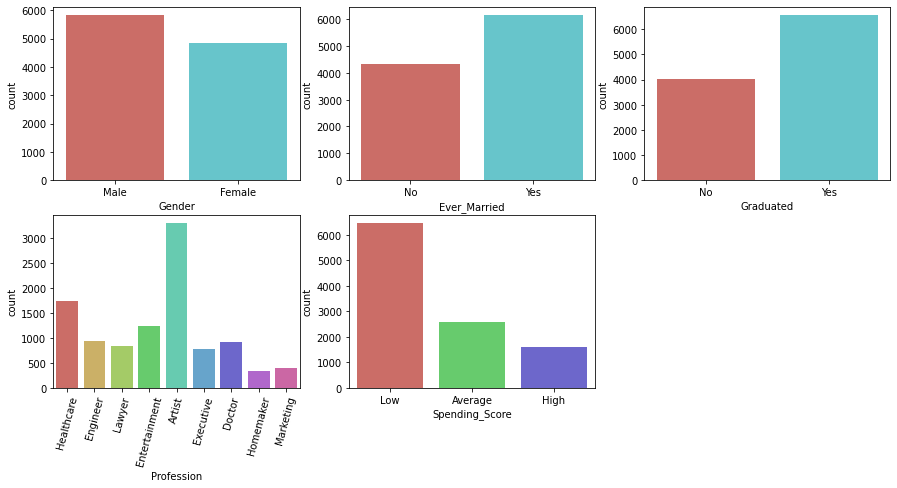

In [54]:
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
sns.countplot('Gender', data = data, palette='hls')
plt.subplot(2,3,2)
sns.countplot('Ever_Married', data = data, palette='hls')
plt.subplot(2,3,3)
sns.countplot('Graduated', data = data, palette='hls')
plt.subplot(2,3,4)
sns.countplot('Profession', data = data, palette='hls')
plt.xticks(rotation = 75)
plt.subplot(2,3,5)
sns.countplot('Spending_Score', data = data, palette='hls')
plt.show();


##### Replacing the NA's in categorical columns with their modes

In [67]:
data['Ever_Married'] = data['Ever_Married'].fillna(data['Ever_Married'].mode()[0])
data['Graduated'] = data['Graduated'].fillna(data['Graduated'].mode()[0])
data['Profession'] = data['Profession'].fillna(data['Profession'].mode()[0])

##### Replacing the NA's in numerical columns with their medians

In [68]:
data['Work_Experience'] = data['Work_Experience'].fillna(data['Work_Experience'].median())
data['Family_Size'] = data['Family_Size'].fillna(data["Family_Size"].median()) 

In [69]:
data.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

##### Get positions for categorical columns

In [70]:
Columnspos= [data.columns.get_loc(col) for col in list(data.select_dtypes("object").columns)]
print("Categorical columns :{}".format(list(data.select_dtypes("object").columns)))
print("Categorical columns Position :{}".format(Columnspos))

Categorical columns :['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']
Categorical columns Position :[0, 1, 3, 4, 6]


##### Standardizing data: All the numerical columns on the same scale

In [72]:
columns_to_normalize     = ['Work_Experience','Family_Size','Age']
data[columns_to_normalize] = data[columns_to_normalize].apply(lambda x: (x - x.mean()) / np.std(x))
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,-1.284406,No,Healthcare,-0.448331,Low,0.787274
1,Female,Yes,-0.330253,Yes,Engineer,-0.448331,Average,0.126594
2,Female,Yes,1.399148,Yes,Engineer,-0.448331,Low,-1.194767
3,Male,Yes,1.399148,Yes,Lawyer,-0.755787,High,-0.534087
4,Female,Yes,-0.210984,Yes,Entertainment,-0.448331,High,2.108635


##### Converting the dataset into matrix

In [73]:
data_matrix = data.to_numpy()
data_matrix

array([['Male', 'No', -1.2844055068336668, ..., -0.44833132883450244,
        'Low', 0.7872743047511633],
       ['Female', 'Yes', -0.3302533185305162, ..., -0.44833132883450244,
        'Average', 0.12659375779997437],
       ['Female', 'Yes', 1.3991475227689445, ..., -0.44833132883450244,
        'Low', -1.1947673361024036],
       ...,
       ['Female', 'No', 0.5642643580036876, ..., -0.44833132883450244,
        'Low', -0.5340867891512147],
       ['Male', 'Yes', 0.2064572873900061, ..., -0.44833132883450244,
        'High', 1.4479548517023524],
       ['Female', 'No', -0.032080759685781585, ..., 2.0113170476850817,
        'Low', 0.12659375779997437]], dtype=object)

##### Elbow method to determine the optimal number of clusters for K-Prototype 

In [83]:
cost = []
for cluster in range(1,15):
    try:
        model = KPrototypes(n_jobs = -1, n_clusters=cluster, init="Huang", random_state=42)
        model.fit_predict(data_matrix, categorical= Columnspos)
        cost.append(model.cost_)
        print("Cluster Initiation: {}".format(cluster))
    except:
        break
        



Cluster Initiation: 1
Cluster Initiation: 2
Cluster Initiation: 3
Cluster Initiation: 4
Cluster Initiation: 5
Cluster Initiation: 6
Cluster Initiation: 7
Cluster Initiation: 8
Cluster Initiation: 9
Cluster Initiation: 10
Cluster Initiation: 11
Cluster Initiation: 12
Cluster Initiation: 13
Cluster Initiation: 14


##### Converting the results into a DataFrame

In [111]:
data_cost = pd.DataFrame({"Cluster":range(1,15),"Cost":cost})
data_cost.head()

,Cluster,Cost
0,1,44243.000000
1,2,34376.129634
2,3,26220.829484
3,4,22409.751866
4,5,19631.362526


##### Visualizing: From the figure below we can pick cluster k=5 as the optimal number of clusters,
##### ie the point at the "elbow" or the point at which the cost start decreasing in a linear fashion.

In [102]:
fig= px.line(data_cost, x="Cluster", y="Cost", title="Optimal number of clusters")
fig.show()

##### Fitting the cluster

In [116]:
model= KPrototypes(n_jobs= -1, n_clusters= 5, init= "Huang",random_state=42)
model.fit_predict(data_matrix, categorical= Columnspos)

array([3, 1, 4, ..., 2, 1, 0], dtype=uint16)

##### Cluster Centroids


In [117]:
model.cluster_centroids_

array([['-0.34452983298192164', '1.8556813340984772',
        '-0.28675860094404654', 'Female', 'Yes', 'Yes', 'Artist', 'Low'],
       ['0.3610372162447082', '-0.4372623902489344',
        '0.47414362620882694', 'Male', 'Yes', 'Yes', 'Artist', 'Average'],
       ['-0.39471528056519417', '-0.4375994801809076',
        '-0.6942889418281639', 'Female', 'No', 'Yes', 'Artist', 'Low'],
       ['-1.0008619919302295', '-0.2946812211781221',
        '1.2343136003313973', 'Male', 'No', 'No', 'Healthcare', 'Low'],
       ['1.6813565979207963', '-0.46972272833547307',
        '-0.6665345403088581', 'Male', 'Yes', 'Yes', 'Lawyer', 'Low']],
      dtype='<U32')

##### Adding the clusters to the DataFrame

In [120]:
data["Cluster labels"]= model.labels_
data["Segment"]= data["Cluster labels"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth",4:"Fifth"})
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Cluster labels,Segment
0,Male,No,-1.284406,No,Healthcare,-0.448331,Low,0.787274,3,Fourth
1,Female,Yes,-0.330253,Yes,Engineer,-0.448331,Average,0.126594,1,Second
2,Female,Yes,1.399148,Yes,Engineer,-0.448331,Low,-1.194767,4,Fifth
3,Male,Yes,1.399148,Yes,Lawyer,-0.755787,High,-0.534087,4,Fifth
4,Female,Yes,-0.210984,Yes,Entertainment,-0.448331,High,2.108635,3,Fourth
